<a href="https://colab.research.google.com/github/XingxinHE/Python-for-Data-Analysis-Notes/blob/master/8_2_Combining_and_Merging_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np


In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

## Database-Style DataFrame Joins

In [4]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
          'data1': range(7)})
df2 = pd.DataFrame({'key': ['a', 'b', 'd'],
          'data2': range(3)})
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [5]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


In [6]:
pd.merge(df1, df2) #默认情况是对overlapped的column进行merge

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


怎么理解这个merge呢？

对key看，只有b和a是重复的，所以只检索这两个。那么d就被排除了。

data1 用 data1 的值， data2 用 data2 的值

In [7]:
#所以最好还是像下面这样写出来比较稳妥
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


默认情况下，merge是用inner方法，也就是说value做的是intersection

相对的，outer就是union

In [10]:
pd.merge(df1, df2, on='key', how='outer')
#但注意不是DF1有多少个，DF2有多少个，加起来就多少个
#因为是union，所以重复的就不会出现

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


若想两边都不同的key，那么可以specify：

left_on,  right_on

In [11]:
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
          'data1': range(7)})
df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'],
          'data2': range(3)})

pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


还有一种叫做many-to-many（多对多）连接的方法

In [12]:
pd.merge(df1, df2, on='key', how='left')
#因为df1有3个b，df2有2个b，所以点积是6个，所以有6个b

,key,data1,data2
0,b,0,1.0
1,b,1,1.0
2,a,2,0.0
3,c,3,NaN
4,a,4,0.0
5,a,5,0.0
6,b,6,1.0


要根据多个键进行合并，传入一个由key组成的list即可

In [13]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
            'key2': ['one', 'two', 'one'],
            'lval': [1, 2, 3]})
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
            'key2': ['one', 'one', 'one', 'two'],
            'rval': [4, 5, 6, 7]})
pd.merge(left, right, on=['key1','key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


suffixes= 是当我们有两个键值一样的df，不像上面那样是对两个key都处理的话，则会出现_x, _y这种情况

In [15]:
pd.merge(left, right, on='key1')
#因为on='key1'，也就是说都对齐key1,那么只有一个key1,因为左边和右边都有key2，所以key2会出现_x(左)，_y（右）

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [16]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


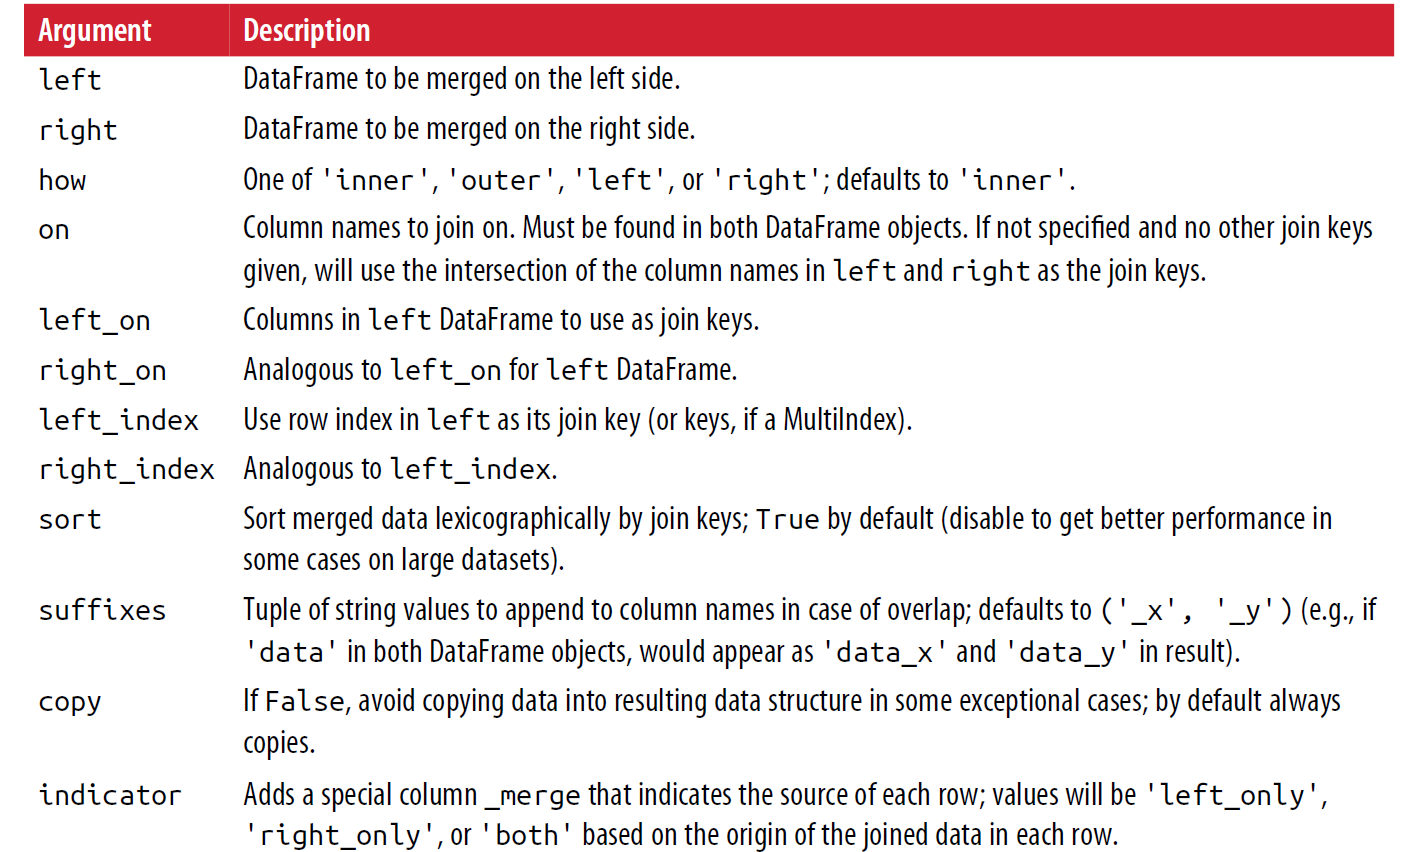

## Merging on Index

In [17]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
            'value': range(6)})
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])

In [18]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [19]:
right1

,group_val
a,3.5
b,7.0


有时候会碰到index和column的值merge，例如上面right1的index和left1的key column重叠

In [20]:
#那么要这么做：
pd.merge(left1, right1, left_on='key', right_index=True)
#left_on指定是key，right_index打开，证明将右边的index拿去对齐

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


In [22]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer') #上面默认是inner，把how换成outer，即union所有东西

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


hierarchically indexed data，这种会复杂点，但是也能操作

In [23]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio',
            'Nevada', 'Nevada'],
            'key2': [2000, 2001, 2002, 2001, 2002],
            'data': np.arange(5.)})
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
            index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio', 'Ohio'],
                [2001, 2000, 2000, 2000, 2001, 2002]],
            columns=['event1', 'event2'])
lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [24]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In [25]:
#其实也并不难，只要把key打开为一个list包含这个hierarchical index即可
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)
#因为左边的key1和key2与右边的index一致

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [26]:
#同理，看看union的效果
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


那么有个疑问了，能否把左右两边的index一致的都合并呢，答案是可以的

In [27]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
            index=['a', 'c', 'e'],
            columns=['Ohio', 'Nevada'])
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
            index=['b', 'c', 'd', 'e'],
            columns=['Missouri', 'Alabama'])
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [28]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [30]:
pd.merge(left2, right2, left_index=True, right_index=True, how='outer')
#可以看到如果是根据index去join的话，column的数目是同一个index的排列组合

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


.join()是为了更方便实现上面功能的function

It can also be used to combine together many DataFrame objects **having the same or similar indexes** but non-overlapping columns.

In [31]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


.join()还能一次性把多个DF根据index一起合并

In [33]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
          index=['a', 'c', 'e', 'f'],
          columns=['New York', 'Oregon'])
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [34]:
#把想要合并的DF以一个list打包写入
left2.join([right2, another], how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0
b,NaN,NaN,7.0,8.0,NaN,NaN
d,NaN,NaN,11.0,12.0,NaN,NaN
f,NaN,NaN,NaN,NaN,16.0,17.0


## Concatenating Along an Axis

上面介绍的方法都是堆叠起来的，也就是说越来越高（row越来越多），下面介绍越来越宽（columns越来越多）

numpy的 concatenate函数

In [35]:
arr = np.arange(12).reshape((3, 4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [37]:
np.concatenate([arr,arr], axis=1)
#可以看到这个数列向右边堆叠起来了

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

pandas的做法，常用到axis=1

In [38]:
s1 = pd.Series([0, 1], index=['a', 'b'])
s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])
s3 = pd.Series([5, 6], index=['f', 'g'])

pd.concat([s1,s2,s3]) #concat三个

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

In [39]:
pd.concat([s1,s2,s3], axis=1)
#concat的做法是outer的

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


如果不想outer,想inner？

join='inner'

In [40]:
s4 = pd.Series([0,1,5,6], index=list('abfg'))
s4

a    0
b    1
f    5
g    6
dtype: int64

In [41]:
pd.concat([s1,s4], axis=1, join='inner')
#这样就只会把intersection部分保留

,0,1
a,0,0
b,1,1


join_axes 标注join后的index有哪些，不管原本的index有没有都可以specify

！！新版的pandas没有这个选项！！

In [42]:
#pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

TypeError: ignored

In [44]:
#specify key可以实现hierarchical index
result = pd.concat([s1, s1, s3], keys=['one', 'two', 'three'])
result #当concat是向下堆叠的时候，可以看到前面one 和 two 分别是重复的ab, ab

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [45]:
#把hierarchical index拆分
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


In [46]:
#当横向堆叠，axis=1的时候，key就不会变成hierarchical index，而是变成column名字
pd.concat([s1,s2,s3], axis=1, keys=['one', 'two', 'three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


同样的逻辑可以运用到DF上面

In [47]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2), index=['a', 'b', 'c'],
          columns=['one', 'two'])
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2), index=['a', 'c'],
          columns=['three', 'four'])
df1

,one,two
a,0,1
b,2,3
c,4,5


In [48]:
df2

,three,four
a,5,6
c,7,8


In [49]:
pd.concat([df1,df2], axis=1, keys=['level1', 'level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [51]:
#如果是pass一个dict进去，则可specify具体哪个DF对应哪个key
#感觉非常重要！！！！！！！！！！！！！！！！！！！！！！
pd.concat({'level': df1, 'level2': df2}, axis=1)

level     level2     
    one two  three four
a     0   1    5.0  6.0
b     2   3    NaN  NaN
c     4   5    7.0  8.0

In [52]:
pd.concat({'level': df1, 'level2': df2}, axis=1, names=['upper', 'lower'])#还可以给不同的hierarchical index命名

upper level     level2     
lower   one two  three four
a         0   1    5.0  6.0
b         2   3    NaN  NaN
c         4   5    7.0  8.0

ignore_index是在concat的时候，让index不会重复的方法

In [53]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])
df2 = pd.DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])
df1

,a,b,c,d
0,0.284082,0.971529,-0.317230,0.075923
1,-1.231316,-0.414564,-0.033556,-0.291111
2,-0.226081,1.857837,-0.376839,-0.509156


In [54]:
df2

,b,d,a
0,-0.634376,-2.040825,-0.289211
1,-1.426720,2.260007,0.524507


In [55]:
#ignore index的效果
pd.concat([df1,df2], ignore_index=True)

,a,b,c,d
0,0.284082,0.971529,-0.317230,0.075923
1,-1.231316,-0.414564,-0.033556,-0.291111
2,-0.226081,1.857837,-0.376839,-0.509156
3,-0.289211,-0.634376,NaN,-2.040825
4,0.524507,-1.426720,NaN,2.260007


In [56]:
#没有ignore index的效果
pd.concat([df1,df2], ignore_index=False)

,a,b,c,d
0,0.284082,0.971529,-0.317230,0.075923
1,-1.231316,-0.414564,-0.033556,-0.291111
2,-0.226081,1.857837,-0.376839,-0.509156
0,-0.289211,-0.634376,NaN,-2.040825
1,0.524507,-1.426720,NaN,2.260007


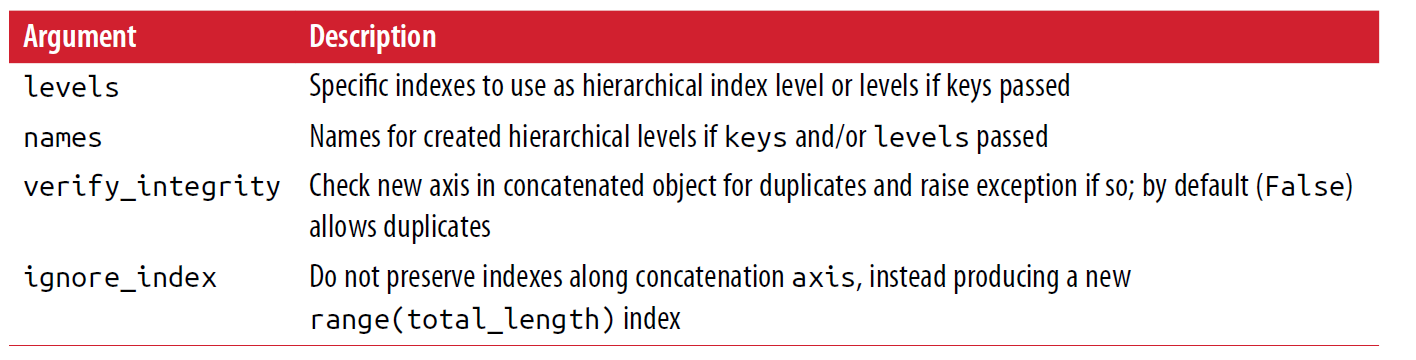

## Combining Data with Overlap

这种combine的方法是，当A有的时候用A，A没有的时候用B（备胎）

In [57]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
        index=['f', 'e', 'd', 'c', 'b', 'a'])
b = pd.Series(np.arange(len(a), dtype=np.float64),
        index=['f', 'e', 'd', 'c', 'b', 'a'])
b[-1] = np.nan
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [58]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [60]:
a.combine_first(b)
#当a有的时候，取a的，没有的话取b
#所以你看到下面的结果是优先取a,没有的话再取b

f    0.0
e    2.5
d    2.0
c    3.5
b    4.5
a    NaN
dtype: float64

对于dataframe也是如此，

In [61]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan],
           'b': [np.nan, 2., np.nan, 6.],
           'c': range(2, 18, 4)})
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7.],
           'b': [np.nan, 3., 4., 6., 8.]})
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [62]:
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [63]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN
